In [1]:
import os
# Prevent TensorFlow from hogging all GPU memory so JAX can use it too
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"

from keras_tft import plot_feature_importance, preprocess_timeseries, plot_probabilistic_forecast, TFTForecaster, timeseries_cv

2025-12-06 00:23:34.633527: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764973414.647800   12233 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764973414.652608   12233 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1764973414.663548   12233 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1764973414.663560   12233 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1764973414.663562   12233 computation_placer.cc:177] computation placer alr

In [2]:
FORECAST_HORIZON = 24
INPUT_LEN = FORECAST_HORIZON * 7  # 7 days of history (reduced from 30 due to small dataset) 
EPOCHS = 5 # Number of epochs for training

# Westbound traffic volume on the I-94 between Minneapolis and St-Paul in Minnesota, starting on September 29, 2016, at 5pm
path = 'data/hourly_traffic.csv'

In [3]:
CUTOFF_DATE = '2016-11-01'
# Preprocess data
# We include Friday in weekend as per original notebook logic (weekday 4,5,6)
# The function now returns history and the full prediction input (history + future)
data, pred_input, test_df, scaler = preprocess_timeseries(
    cutoff_date=CUTOFF_DATE,
    target_col='traffic_volume',
    file_path=path,
    forecast_horizon=FORECAST_HORIZON,
    is_holiday=True,
    country='US',
    is_weekend=True
)

data.head()

,id_column,timestamp,y,is_holiday,is_weekend,hour_sin,hour_cos
0,0,2016-09-29 17:00:00,0.844240,0,0,-0.965926,-2.588190e-01
1,0,2016-09-29 18:00:00,0.619395,0,0,-1.000000,-1.836970e-16
2,0,2016-09-29 19:00:00,0.508953,0,0,-0.965926,2.588190e-01
3,0,2016-09-29 20:00:00,0.402789,0,0,-0.866025,5.000000e-01
4,0,2016-09-29 21:00:00,0.351767,0,0,-0.707107,7.071068e-01


In [4]:
# Initialize TFT Forecaster model
# We need to specify feature counts upfront
# Target: y (1)
# Future Covariates: is_holiday, is_weekend, hour_sin, hour_cos (4)
# Past Features = Target + Future Covariates = 1 + 4 = 5
# Future Features = Future Covariates = 4
# Static Features = 0

model = TFTForecaster(
    input_chunk_length=INPUT_LEN, 
    output_chunk_length=FORECAST_HORIZON, 
    quantiles=[0.1, 0.5, 0.9],
    num_past_features=5,
    num_future_features=4,
    num_static_features=0
)

In [5]:
model.summary()

Model: "TemporalFusionTransformer"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ past_input          │ (None, 168, 5)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 5)         │          0 │ past_input[0][0]  │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │        768 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 128)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ future_input        │ (None, 24, 4)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vsn_past            │ [(None, 168,      │    333,570 │ past_input[0][0], │
│ (MultivariateVaria… │ 128), (None, 5)]  │            │ lambda[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vsn_future          │ [(None, 24, 128), │    266,840 │ future_input[0][… │
│ (MultivariateVaria… │ (None, 4)]        │            │ lambda[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ grn_enrich_past     │ (None, 168, 128)  │     82,688 │ vsn_past[0][0],   │
│ (GatedResidualNetw… │                   │            │ lambda[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ grn_enrich_fut      │ (None, 24, 128)   │     82,688 │ vsn_future[0][0], │
│ (GatedResidualNetw… │                   │            │ lambda[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 192, 128)  │          0 │ grn_enrich_past[… │
│ (Concatenate)       │                   │            │ grn_enrich_fut[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_shared (LSTM)  │ [(None, 192,      │    131,584 │ concatenate[0][0… │
│                     │ 128), (None,      │            │ lambda[0][0],     │
│                     │ 128), (None,      │            │ lambda[0][0]      │
│                     │ 128)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 168, 128)  │          0 │ lstm_shared[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 24, 128)   │          0 │ lstm_shared[0][0] │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gated_linear_unit_… │ (None, 168, 128)  │     33,024 │ get_item[0][0]    │
│ (GatedLinearUnit)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gated_linear_unit_… │ (None, 24, 128)   │     33,024 │ get_item_1[0][0]  │
│ (GatedLinearUnit)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 168, 128)  │          0 │ gated_linear_uni… │
│                     │                   │            │ grn_enrich_past[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 24, 128)   │          0 │ gated_linear_uni… │
│                     │                   │            │ grn_enrich_fut[0

 Total params: 1,151,613 (4.39 MB)

 Trainable params: 1,151,613 (4.39 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
# Train the model
# Note: hour_sin and hour_cos are added automatically by preprocess_timeseries for hourly data
model.fit(
    data, 
    target_col="y", 
    future_cov_cols=["is_weekend", "is_holiday", "hour_sin", "hour_cos"], 
    epochs=EPOCHS,
    use_early_stopping=True, early_stopping_patience=2
)

2025-12-06 00:23:38.721938: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
I0000 00:00:1764973418.722971   12233 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6


Training with tf.data pipeline...
Past features: 5 | Future features: 4 | Static features: 0
Epoch 1/5
19/19 ━━━━━━━━━━━━━━━━━━━━ 137s 3s/step - loss: 0.2508 - learning_rate: 0.0010
Epoch 2/5
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1418 - learning_rate: 0.0010
Epoch 3/5
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1089 - learning_rate: 0.0010
Epoch 4/5
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0930 - learning_rate: 0.0010
Epoch 5/5
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0816 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 5.


In [7]:
# Forecast
forecast = model.predict(pred_input)
forecast

,q10,q50,q90
timestamp,,,
2016-11-01 01:00:00,-0.084638,0.029289,0.110220
2016-11-01 02:00:00,-0.087133,0.020163,0.088264
2016-11-01 03:00:00,-0.045892,0.063383,0.135750
2016-11-01 04:00:00,0.052614,0.170577,0.260105
2016-11-01 05:00:00,0.287111,0.422785,0.533834
2016-11-01 06:00:00,0.778174,0.920844,1.038961
2016-11-01 07:00:00,0.813328,0.942238,1.081025
2016-11-01 08:00:00,0.689037,0.809325,0.942202
2016-11-01 09:00:00,0.608735,0.714660,0.836323


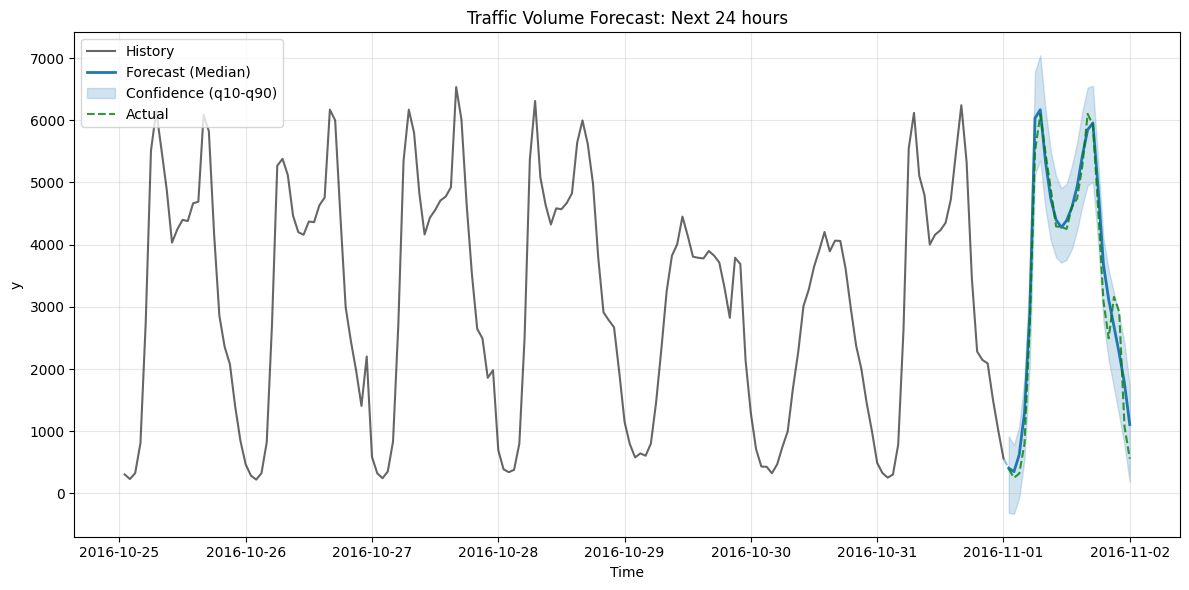

In [8]:
# Plot the probabilistic forecast
plot_probabilistic_forecast(
    history_df=data,
    forecast_df=forecast, 
    target_col="y",
    scaler=scaler, actual_df=test_df,
    timeseries_name="Traffic Volume",
    time_col="timestamp",      
    history_length=INPUT_LEN     
)

In [9]:
results = timeseries_cv(
    model=model,
    df=data,
    num_windows=5,
    forecast_horizon=FORECAST_HORIZON,
    target_col="y",
    future_cov_cols=["is_weekend", "is_holiday", "hour_sin", "hour_cos"]
)


CROSS-VALIDATION: 2016-10-28 to 2016-11-01 (Test Ends)
Forecast Horizon: 24 hours | Windows: 5

Window   1 | Date: 2016-10-27 | Train:  656 hours | RMSE:   0.04 | MAE:   0.03 | MAPE: 41.03%
Window   2 | Date: 2016-10-28 | Train:  680 hours | RMSE:   0.05 | MAE:   0.04 | MAPE: 22.38%
Window   3 | Date: 2016-10-29 | Train:  704 hours | RMSE:   0.09 | MAE:   0.07 | MAPE: 23.70%
Window   4 | Date: 2016-10-30 | Train:  728 hours | RMSE:   0.11 | MAE:   0.08 | MAPE: 43.54%
Window   5 | Date: 2016-10-31 | Train:  752 hours | RMSE:   0.05 | MAE:   0.03 | MAPE: 17.67%

CROSS-VALIDATION SUMMARY
Total Windows: 5
Overall RMSE: 0.07
Overall MAE:  0.05
Overall MAPE: 29.66%



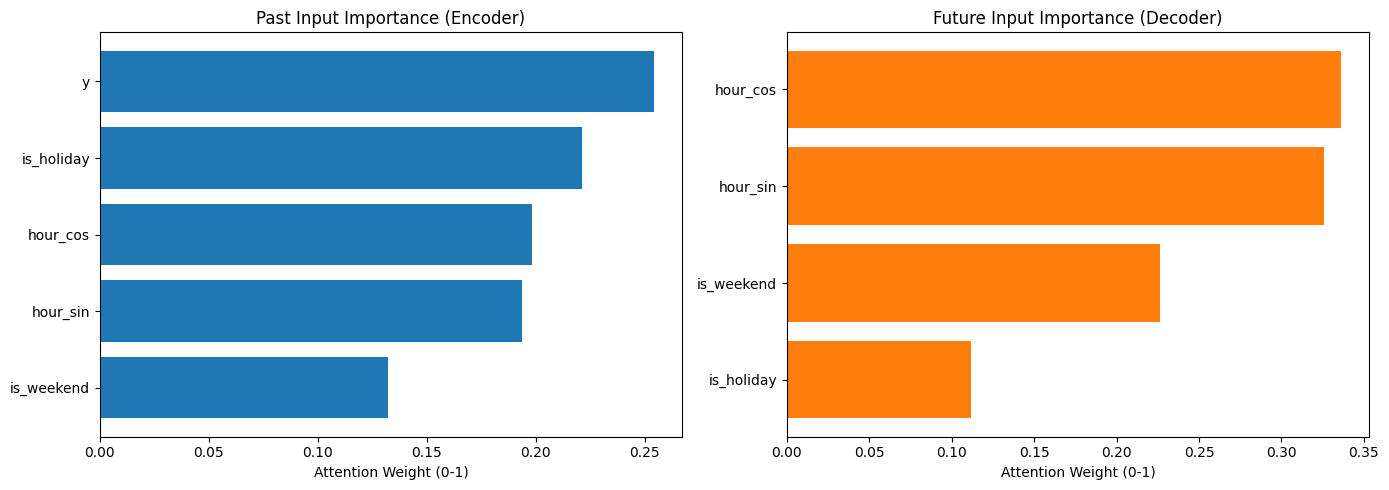

In [10]:
# Feature Importance Analysis

# Extract feature importance
importance_results = model.get_feature_importance(data)

# Plot importance (handles printing and plotting internally)
plot_feature_importance(importance_results)